<a href="https://colab.research.google.com/github/EdnahM/NLP_POS_Luhya/blob/dev/POS_Luhya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### Natural Language Processing
### Edna Wairimu Mugoh
### C241-01-2293/2022

Below project is a POS task on Luhya Dataset-Specialized with the Busukusu Speaking

Project Parts
1. Data preprocessing
2. Training and Modelling
3. Model Evaluation
4. Developing a usable endpoint
5. Deployed POS app for Bukusu

# Data Preporcessing


### Import required libraries


In [1]:
import pandas as pd
import numpy as np
import csv

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
! pip install --upgrade scikit-learn
import sklearn
# Check scikit-learn version
print("scikit-learn version:", sklearn.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
scikit-learn version: 1.4.2


### Load Dataset


In [31]:
import os
os.listdir()

['.config', 'drive', 'sample_data']

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [32]:
train_df =  pd.read_csv("/content/drive/MyDrive/MSC-DS-2023/combined_bukusu_train_data.csv", header=0)
test_df =  pd.read_csv("/content/drive/MyDrive/MSC-DS-2023/combined_bukusu_test_data.csv", header=0)

In [33]:
train_df.head()

,WORD,SPEECH TAG
0,BAABIYA,NN
1,BAALA,NN
2,BAABANGURA,ADJ
3,BAALA,NN
4,BALUBIRI,ADJ


In [34]:
train_df.dtypes

WORD          object
SPEECH TAG    object
dtype: object

In [35]:
train_df.shape

(54542, 2)

### Clean Dataset

In [36]:
pos_counts = train_df['SPEECH TAG'].value_counts()
print(pos_counts)

SPEECH TAG
NN            10439
V              7561
ADP            5593
nn             3253
CONJ           3113
v              2498
PRON           2416
DET            2398
PUNCT          2096
conj           1894
ADJ            1657
ADV            1072
punct          1071
PUNC            998
adp             824
pron            767
NUM             642
adv             445
adj             420
PREP            262
det             186
num             143
X                80
POS              23
PRO              18
N                16
ADJE             14
inter            12
x                11
AP               10
n                10
pro               9
con               8
Pron              7
D                 7
pr                6
AV                4
AD                4
PART              4
DP                4
cv                4
XX                3
dp                3
VV                3
ART               3
A                 3
AD[               2
SPEECH TAG        2
C                 2
C0NJ     

#### Function to standardize the various variations of pos


In [37]:
def standardize_pos(pos):
    """
    Standardize POS tags to basic presentation
    """
    pos_mapping = {
        'N': ['N', 'NN', 'NNN', 'NNNN', 'NOUN','noun', 'nn','NNC', 'NNS','nn4','NO','NU','ñn'], # Noun
        'V': ['V', 'VB', 'verb', 'vb','v','VV', 'vv'], # Verb
        'PRON':['PR','NNP','PROM','PRO','PRON', 'P','pro', 'PROUN','PR0N'], # Pronoun
        'PUNCT':['punct','punc','PUNT'], # Punctuation
        'ADJ': ['AD', 'ADJ','adj', 'AD [','ADO',' adje','AADJ','DJ','ADJE','ADDJ','AJ','AD['], # Adjective
        'ADV': ['ADV','AV','adv','DV','AV', 'AADV','DADV'], # Adverb
        'PREP':['PREP', 'prep','pre'], # Preposition
        'CONJ': ['conju', 'conj','CON','C','c', 'COJ', 'C0NJ'], # Conjuction
        'NUM': ['NUM', 'num',], # Integer
        'DT': ['DET','DT','D'], # Determiner
        'INTJ': ['inter',''], # Interjection
        'XX' : ['XX', 'X'], # Unknown
        'ADP' :['AP', 'ADP','adp','ADDP','addp','APD', 'adadp','dp'], # Adposition

    }

   # Checking Null POC
    if pd.isna(pos):
      pos = 'PUNCT'
      return pos

    pos_upper = pos.upper().strip()

    for standard_pos, variations in pos_mapping.items():
        for variation in variations:
            if pos_upper == variation.upper():
                return standard_pos

    return pos


In [38]:
def standardize_pos_column(df, column_name):
    df[column_name] = df[column_name].apply(standardize_pos)
    return df

In [39]:
cleaned_df = standardize_pos_column(train_df, 'SPEECH TAG')

In [40]:
# Display the filtered DataFrame
pos_counts = cleaned_df['SPEECH TAG'].value_counts()
print("Cleaned  POS Dataframe")
print(pos_counts)

Cleaned  POS Dataframe
SPEECH TAG
N             13731
V             10064
PUNCT          8607
ADP            6439
CONJ           5023
PRON           3230
DT             2591
ADJ            2103
ADV            1525
NUM             785
PREP            263
XX               94
POS              23
INTJ             14
PART              4
cv                4
ART               3
A                 3
ne                2
mm                2
SPEECH TAG        2
ON                1
TEMA              1
ABAAELESIA        1
MASA              1
HATATI            1
YEMA              1
PU                1
NM                1
YETURI            1
OMUKHAANA         1
HH                1
NE                1
OU                1
O                 1
po                1
MBOOLELE          1
BULI              1
NGA               1
KHUKHWAMA         1
CHIRUPIA          1
asp               1
b                 1
asinyikhwa        1
um                1
bakaambisi        1
chambukha         1
mala              1
pun   

#### Eliminate all rows with pos_count count of 1

In [53]:
train_df_v1 = train_df.copy()
pos_to_keep = pos_counts[pos_counts != 1].index

cleaned_df = train_df[train_df['SPEECH TAG'].isin(pos_to_keep)]

In [60]:
def filter_dataframe_by_words(df, column_name, words):
    """
      Filter Dataframe
    """
    mask = df[column_name].str.contains('|'.join(words), case=False)
    return df[~mask]

words_to_exclude = ['SPEECH TAG', 'POS', 'PART','cv','A', 'ART','mm','ne']

cleaned_df = filter_dataframe_by_words(cleaned_df, 'SPEECH TAG', words_to_exclude)


In [61]:
cleaned_df['SPEECH TAG'].value_counts()

SPEECH TAG
N        13731
V        10064
PUNCT     8607
CONJ      5023
PRON      3230
DT        2591
NUM        785
PREP       263
XX          94
INTJ        14
Name: count, dtype: int64

#### Small visualization on the POS count

In [62]:
pos_counts = cleaned_df['SPEECH TAG'].value_counts()
print("Cleaned  POS Dataframe")
print(pos_counts)


Cleaned  POS Dataframe
SPEECH TAG
N        13731
V        10064
PUNCT     8607
CONJ      5023
PRON      3230
DT        2591
NUM        785
PREP       263
XX          94
INTJ        14
Name: count, dtype: int64


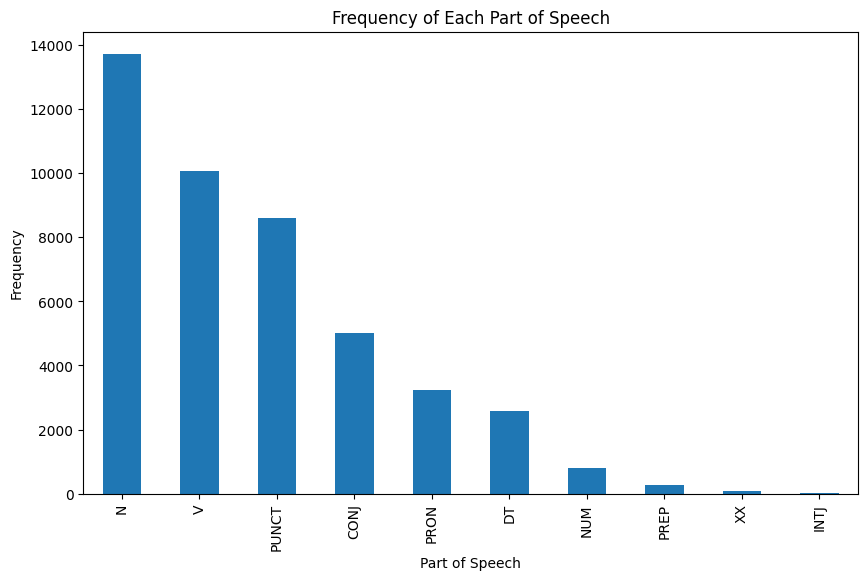

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
pos_counts.plot(kind='bar')
plt.title('Frequency of Each Part of Speech')
plt.xlabel('Part of Speech')
plt.ylabel('Frequency')
plt.show()

### Tokenization and Lemmatization on the given Words

In [64]:
import nltk
from nltk.tokenize import word_tokenize
import spacy

In [65]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [66]:
cleaned_df['WORD'] = cleaned_df['WORD'].astype(str)
cleaned_df['TOKENS'] = cleaned_df['WORD'].apply(word_tokenize)


In [67]:
nlp = spacy.load('en_core_web_sm') ## Lemmatization

In [68]:
def lemmatize_text(text):
    doc = nlp(" ".join(text))
    return [token.lemma_ for token in doc]

In [69]:
cleaned_df['LEMMAS'] = cleaned_df['TOKENS'].apply(lemmatize_text)

In [70]:
print(cleaned_df.tail(10))

                WORD SPEECH TAG           TOKENS           LEMMAS
54530              .      PUNCT              [.]              [.]
54531         Khwola          V         [Khwola]         [Khwola]
54533       kumubili          N       [kumubili]       [kumubili]
54534  kwanyooleekha          V  [kwanyooleekha]  [kwanyooleekha]
54535             Se      PUNCT             [Se]             [Se]
54536      okhoyeele          V      [okhoyeele]      [okhoyeele]
54537       omukusie          V       [omukusie]       [omukusie]
54539       omukhole          V       [omukhole]       [omukhole]
54540     balarobora          V     [balarobora]     [balarobora]
54541        emasoti          N        [emasoti]        [emasoti]


# Model Training

### Using the NLTK Library for training

#### Install and Import the required Libraries

In [71]:
! pip install nltk spacy textblob stanfordnlp pattern gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 42.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.8/348.8 kB 43.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_c

In [72]:
import nltk
import spacy
from textblob import TextBlob
import stanfordnlp
import pattern
import gensim
from nltk.corpus import treebank

#### Function to define POS:

In [73]:
def features(word):
    return {'word': word}

In [74]:
# Extract features from your dataset
data = []
for index, row in cleaned_df.iterrows():
    word = row['WORD']
    tag = row['SPEECH TAG']
    featureset = features(word)
    data.append((featureset, tag))

In [75]:
# Split the data into training and testing sets
train_size = int(0.8 * len(data))
train_set, test_set = data[:train_size], data[train_size:]

#### Maxentropy Classification

In [76]:
classifier = nltk.MaxentClassifier.train(train_set)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -2.30259        0.002
             2          -0.68138        0.937
             3          -0.45836        0.937
             4          -0.35840        0.937
             5          -0.30134        0.937
             6          -0.26436        0.937
             7          -0.23843        0.937
             8          -0.21923        0.937
             9          -0.20444        0.937
            10          -0.19269        0.937
            11          -0.18313        0.937
            12          -0.17521        0.937
            13          -0.16853        0.937
            14          -0.16282        0.937
            15          -0.15789        0.937
            16          -0.15358        0.937
            17          -0.14979        0.937
            18          -0.14643        0.937
            19          -0.14342        0.937
 

In [77]:
accuracy = nltk.classify.accuracy(classifier, test_set)
print("Accuracy:", accuracy)

Accuracy: 0.7178245693052584


#### Save the predictions to a pickle file.

In [78]:
import pickle
with open('maxentpos_tagger.pickle', 'wb') as f:
    pickle.dump(classifier, f)

#### Random Forest Classifier

In [79]:
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction import DictVectorizer


In [80]:
def features(sentence, index):
    word = sentence[index]
    featureset = {'word': word,
                  'word_length': len(word),
                  'has_numbers': any(char.isdigit() for char in word),
                  'has_special_chars': any(not char.isalnum() for char in word),
                  'position_in_sentence': index}
    return featureset

In [81]:
data = []
for index, row in cleaned_df.iterrows():
    word = row['WORD']
    tag = row['SPEECH TAG']
    featureset = features(word_tokenize(word), 0)
    data.append((featureset, tag))


In [82]:
X = [d[0] for d in data]
y = [d[1] for d in data]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Using the Random Forest classifier

In [83]:
vectorizer = DictVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [84]:
# Train a classifier (e.g., Random Forest) using the transformed features
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

#### Prediction

In [85]:
X_test_vec = vectorizer.transform(X_test)

y_pred = classifier.predict(X_test_vec)


In [86]:
print(y_pred)

['CONJ' 'NUM' 'N' ... 'N' 'N' 'V']


#### Performance Evaluation

In [87]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8647674811395113


#### Hyperpaparmeter Tuning
Below using the 5-folds to improve on the model


In [88]:
X_vec = vectorizer.fit_transform(X)
cv_scores = cross_val_score(classifier, X_vec, y, cv=10)
print("Cross-Validation Mean Accuracy:", cv_scores.mean())

Cross-Validation Mean Accuracy: 0.8290393112094303


In [89]:
print(X_vec)

  (0, 0)	0.0
  (0, 1)	0.0
  (0, 2)	0.0
  (0, 470)	1.0
  (0, 9410)	7.0
  (1, 0)	0.0
  (1, 1)	0.0
  (1, 2)	0.0
  (1, 473)	1.0
  (1, 9410)	5.0
  (2, 0)	0.0
  (2, 1)	0.0
  (2, 2)	0.0
  (2, 473)	1.0
  (2, 9410)	5.0
  (3, 0)	0.0
  (3, 1)	0.0
  (3, 2)	0.0
  (3, 473)	1.0
  (3, 9410)	5.0
  (4, 0)	0.0
  (4, 1)	0.0
  (4, 2)	0.0
  (4, 471)	1.0
  (4, 9410)	5.0
  :	:
  (44397, 0)	0.0
  (44397, 1)	0.0
  (44397, 2)	0.0
  (44397, 8560)	1.0
  (44397, 9410)	9.0
  (44398, 0)	0.0
  (44398, 1)	0.0
  (44398, 2)	0.0
  (44398, 8665)	1.0
  (44398, 9410)	8.0
  (44399, 0)	0.0
  (44399, 1)	0.0
  (44399, 2)	0.0
  (44399, 8659)	1.0
  (44399, 9410)	8.0
  (44400, 0)	0.0
  (44400, 1)	0.0
  (44400, 2)	0.0
  (44400, 4829)	1.0
  (44400, 9410)	10.0
  (44401, 0)	0.0
  (44401, 1)	0.0
  (44401, 2)	0.0
  (44401, 5943)	1.0
  (44401, 9410)	7.0


#### Saving the models Output

In [90]:
import pickle
with open('/content/drive/MyDrive/MSC-DS-2023/rf_pos_tagger.pickle', 'wb') as f:
    pickle.dump(classifier, f,protocol=4)

In [91]:
import pickle
import sklearn

# Check scikit-learn version
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.4.2


### Using the Spacy Library for training

# Model Evaluation

#